## Prepare TCGA counts

In [1]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt 
from itertools import chain
import numpy as np
import pickle
path = Path('data')
dataset = 'KICH' #Kidney Chromophobe
tcga_path = Path(path/dataset)
path_tarp = Path('../data')
path_input = Path('../data/all_cdna_subsets')

### Translate exon counts to GRCh38 and filter

translate exon count positions from GRCh37 to GRCh38
Reading liftover chains
Mapping coordinates
238796/239322 exon positions are kept.
0.22% were lost during liftOver.
load exon data file from disk
Exon and miRNA counts have 89 common patient ids.
get all overlap matches for assigning exon id
  Number exons before: 238796
  Number exons after: 213430 = 89.38% of exons left, for which we have ids.
remove duplicated exons
  Number exons before: 213430
  Number exons after: 212679
filter out zero genes
  Number exons before: 212679 with average 20.14% of NaNs.


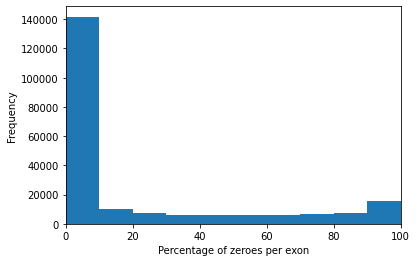

  3503 genes (14.99%) are filtered out.
  Number exons after: 196077 with average 14.35% of NaNs.


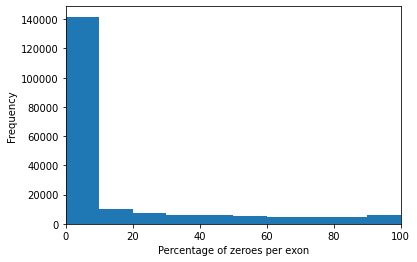

filter out genes without AS (with variance < 0.05)
  Number genes before: 19872 Number exons before: 196077


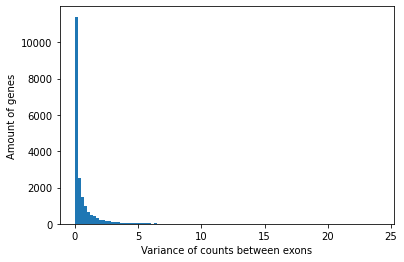

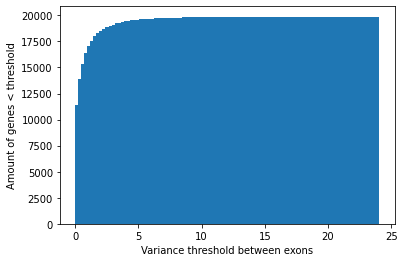

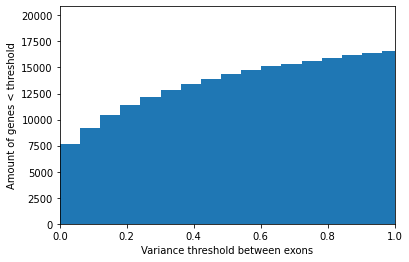

  Number genes after: 12501 Number exons after: 146387
filter out exons with variance <= 0.3 between samples
  Number exons before: 146387


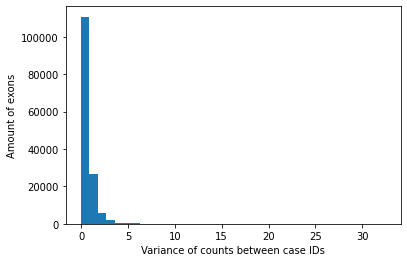

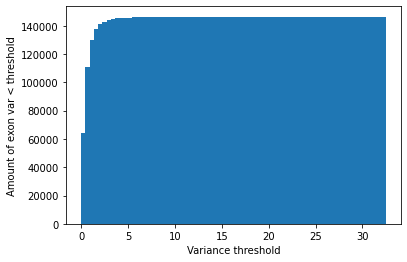

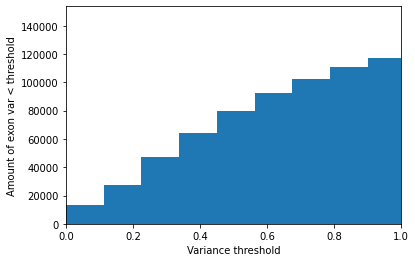

  Number exons after: 105739


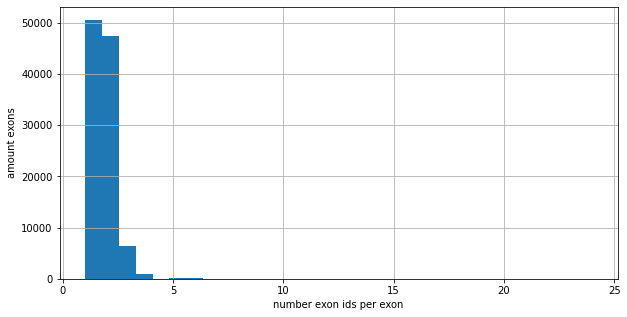

exon_id,"ENSE00000000004,ENSE00001151806","ENSE00000000011,ENSE00002052017","ENSE00000000034,ENSE00001759405","ENSE00000000046,ENSE00001525888,ENSE00003751440","ENSE00000000055,ENSE00001706824,ENSE00001819021","ENSE00000000068,ENSE00001929094",ENSE00000000080,"ENSE00000000090,ENSE00001641760",ENSE00000000095,ENSE00000000098,...,"ENSE00003898856,ENSE00000893258",ENSE00003898862,ENSE00003898866,ENSE00003898873,"ENSE00003898885,ENSE00001046995,ENSE00003898826","ENSE00003898891,ENSE00003898406,ENSE00003692170","ENSE00003898892,ENSE00003898462","ENSE00003898925,ENSE00001475019","ENSE00003898929,ENSE00003636032,ENSE00003898111","ENSE00003898955,ENSE00000893255"
case_id,,,,,,,,,,,,,,,,,,,,,
TCGA-KL-8323-01,4.8985,1.6285,2.4041,2.5345,2.1599,3.1684,1.8335,0.7940,3.0155,0.4992,...,2.6128,2.1417,2.2693,3.6163,5.0361,3.6584,3.5670,2.1104,2.5988,2.3276
TCGA-KL-8324-01,4.5504,0.1141,0.1442,2.9364,1.3113,2.1229,1.0438,0.8626,1.9502,0.9761,...,1.1336,0.2127,1.2875,1.9770,2.8984,2.2640,2.4340,3.0804,1.3988,0.5099
TCGA-KL-8324-11,4.9434,0.7591,3.5127,3.6062,2.7992,3.1905,2.7627,2.2243,3.0680,2.5537,...,2.3015,2.3389,3.1826,5.4616,5.3613,3.5972,3.6158,1.6621,2.0730,2.4340
TCGA-KL-8325-01,5.2853,2.6351,1.9011,2.4696,1.6811,2.8979,2.2596,1.1085,2.9328,0.2195,...,2.8677,2.2806,2.3176,3.5528,6.1575,4.6462,4.7193,2.5519,3.2958,3.0416
TCGA-KL-8326-01,5.0798,0.0000,0.5038,0.7051,2.2165,2.4024,0.7391,1.4013,2.6685,0.8413,...,1.0716,0.1167,1.3423,1.1593,1.9644,1.9411,1.8659,0.9759,0.5367,0.9536


In [3]:
#download GDC ChGR37 exon expression data from XENA
def download_expression_data(tcga_path, dataset):
    if not tcga_path.exists():
        !mkdir tcga_path
    if not Path(tcga_path/'HiSeqV2_exon').is_file():
        print(f'Download {dataset} exon expression data from TCGA')
        !wget 'https://tcga.xenahubs.net/download/TCGA.'$dataset'.sampleMap/HiSeqV2_exon.gz'
        !gunzip HiSeqV2_exon.gz
        !mv HiSeqV2_exon tcga_path
    
#read in exon counts & translate exon positions to GRCH38 using liftover
def read_exon_counts(tcga_path):
    f = Path(tcga_path/'exon_counts.feather')
    if f.is_file():
        print('read translated exon_counts from file')
        exon_counts = pd.read_feather(f)
    else:
        print('translate exon count positions from GRCh37 to GRCh38')
        counts_37 = pd.read_csv(tcga_path/'HiSeqV2_exon', delimiter='	')
        exon_counts = counts_37.copy()
        #split sample in seperate columns chromosome, start, end, strand
        new = exon_counts['sample'].str.split(':', 2, expand=True) 
        exon_counts['chrom_old'] = new[0].astype('category')
        new2 = new[1].str.split('-', 1, expand=True)
        exon_counts['start_old'] = new2[0].astype(int)
        exon_counts['end_old'] = new2[1].astype(int)
        exon_counts['strand_old'] = new[2].astype('category')
        #save positions to BED input file
        exon_counts['score'] = '.'
        exon_counts.to_csv(tcga_path/'exon_hg19_pos.bed', sep='\t', columns=['chrom_old','start_old','end_old','sample','score','strand_old'], header=False, index=False)
        #translate positions from GRCh37 to GRCh38
        !../liftOver $tcga_path/exon_hg19_pos.bed data/hg19ToHg38.over.chain.gz $tcga_path/exon_hg38_pos.bed $tcga_path/unlifted.bed
        #read in translated positions from liftOver output BED file
        translated_positions = pd.read_csv(tcga_path/'exon_hg38_pos.bed', delimiter='	', names=['chromosome_name','chrom_exon_start','chrom_exon_end','id','score','strand'])
        exon_counts = exon_counts.merge(translated_positions[['chromosome_name','chrom_exon_start','chrom_exon_end','id','strand']], left_on='sample', right_on='id', how='inner',validate='1:1')
        exon_counts.drop(['sample','chrom_old','strand_old','start_old','end_old','score'], axis=1, inplace=True)
        #transform strand {-,+} to {-1,+1}
        exon_counts['strand'] = exon_counts.apply(lambda row: '-1' if row.strand == '-' else '1', axis=1).astype('category')
        exon_counts['chromosome_name'] = exon_counts['chromosome_name'].str[3:].astype('category')
        exon_counts[['chrom_exon_start','chrom_exon_end']] = exon_counts[['chrom_exon_start','chrom_exon_end']].astype('Int64')
        print(f'{len(exon_counts)}/{len(counts_37)} exon positions are kept.\n{(1-(len(exon_counts)/len(counts_37)))*100:.2f}% were lost during liftOver.')
        exon_counts.to_feather(f)  
    return exon_counts

#read in Ensembl exon info
# returns format {transcript_id : {exon_id : data}}
def read_in_fasta(file):
	file = open(file,'r').readlines()
	dict_ = {}
	for id_, line in enumerate(file):
		if line[0] == '>': 	# data is in next line
			transcript_id = re.search('ENST[^_]*',line).group(0)
			exon_id = re.search('ENSE[^\n]*',line).group(0)
			data = file[id_+1][:-1]
			data = int(data) if data != 'NA' else None
			dict_[transcript_id] = dict_.get(transcript_id, {})
			dict_[transcript_id][exon_id] = data
	return dict_

#returns format {transcript_id : {exon_id : chromosome_start}}, {transcript_id : {exon_id : start}}, {transcript_id : {exon_id : end}}, pandas DataFrame [exon_id, transcript_id, chrom_exon_start, chrom_exon_end]
def calc_exon_data(path):
	feather_file = Path(path/'exon_info.feather')
	if feather_file.is_file():
		print('load exon data file from disk')
		exon_info = pd.read_feather(feather_file)
	else:
		chrom_exon_starts = read_in_fasta(path/'all_exon_start.fasta')
		chrom_exon_ends = read_in_fasta(path/'all_exon_end.fasta')
		exon_info = {}
		for tid in chrom_exon_starts:
			sorted_ = {k: v for k, v in sorted(chrom_exon_starts[tid].items(), key=lambda item: item[1])}
			for eid in sorted_:
				chrom_exon_start = chrom_exon_starts[tid][eid]
				chrom_exon_end = chrom_exon_ends[tid][eid]
				exon_info[eid] = [tid, chrom_exon_start, chrom_exon_end]
				#write to disk
		exon_info = pd.DataFrame.from_dict(exon_info, orient='index', columns=['transcript_id','chrom_exon_start', 'chrom_exon_end']).reset_index()
		exon_info = exon_info.rename(columns={'index': "exon_id"})
		exon_info.to_feather(feather_file)
	return exon_info

def read_in_ensembl_exon_info(path):
    df_gene = pd.read_csv(path/'gene_infos.csv', dtype={'ensembl_gene_id':str,'ensembl_gene_id_version':str,'ensembl_transcript_id':str, 'ensembl_transcript_id_version':str, 'chromosome_name':'category', 'strand':'int8', 'start_position':int, 'end_position':int})
    del df_gene['Unnamed: 0']
    df_gene[['strand']] = df_gene[['strand']].astype('str').astype('category')
    df_exon = calc_exon_data(path) # exon starts and ends per transcript + exon id
    df_exon = df_exon.merge(df_gene, left_on = 'transcript_id', right_on = 'ensembl_transcript_id', how='left')
    df_exon[['chrom_exon_start','chrom_exon_end','start_position','end_position']] = df_exon[['chrom_exon_start','chrom_exon_end','start_position','end_position']].astype('Int64')
    df_exon['chromosome_name'] = df_exon['chromosome_name'].apply((lambda x: (x[4:] if x.startswith('CHR') else x)))
    df_exon[['strand']] = df_exon[['strand']].astype('str').astype('category')
    return df_exon

#get all direct matches with GRCh38
def get_direct_exon_id(exon_counts_input, df_exon):
    exon_counts_direct = exon_counts_input[['chromosome_name','strand','chrom_exon_start','chrom_exon_end','id']].merge(df_exon[['exon_id','chromosome_name','strand','chrom_exon_start','chrom_exon_end']], left_on = ['chromosome_name','strand','chrom_exon_start','chrom_exon_end'], right_on = ['chromosome_name','strand','chrom_exon_start','chrom_exon_end'], how='left')
    exon_counts_direct.rename(columns = {'exon_id':'exon_id_38_direct','chrom_exon_start':'chrom_exon_start_38','chrom_exon_end':'chrom_exon_end_38','strand':'strand_38'}, inplace = True)
    exon_counts_direct.loc[exon_counts_direct.exon_id_38_direct == 'nan','exon_id_38_direct'] = None
    exon_counts_direct['nr_exonids_38'] = 1
    exon_counts_direct = exon_counts_direct.groupby('id', as_index=False).agg({'exon_id_38_direct': lambda x:','.join(x.astype(str)),'chrom_exon_start_38':'first','chrom_exon_end_38':'first','strand_38':'first','chromosome_name':'first','nr_exonids_38':'sum'})
    exon_counts_direct.loc[exon_counts_direct.exon_id_38_direct == 'nan','exon_id_38_direct'] = None
    return exon_counts_direct

#get all overlap matches
def get_overlap_exon_id(version, df_exon, exon_counts_direct, exon_counts_input, threshold):
    import pyranges as pr
    ranges_counts = exon_counts_direct.rename(columns = {'chromosome_name':'Chromosome',f'chrom_exon_start_{version}':'Start',f'chrom_exon_end_{version}':'End'})
    ranges_counts['Chromosome'] = pd.Categorical(ranges_counts.Chromosome)
    ranges_counts['Strand'] = '-'
    ranges_counts.loc[ranges_counts[f'strand_{version}'] == '1', 'Strand'] = '+'
    del ranges_counts[f'strand_{version}']
    ranges_counts['Strand'] = pd.Categorical(ranges_counts.Strand)
    ranges_exon = df_exon[['chromosome_name','chrom_exon_start','chrom_exon_end','exon_id','strand','ensembl_transcript_id','ensembl_gene_id']].copy()
    ranges_exon.columns = f"Chromosome Start End exon_id_{version}_overlap strand transcript_id gene_id".split()
    ranges_exon['Strand'] = '-'
    ranges_exon.loc[ranges_exon['strand'] == '1', 'Strand'] = '+'
    del ranges_exon['strand']
    ranges_exon['Strand'] = pd.Categorical(ranges_exon.Strand)
    ranges_counts, ranges_exon = pr.PyRanges(ranges_counts), pr.PyRanges(ranges_exon)
    exon_counts = ranges_counts.join(ranges_exon, report_overlap=True, how='left',suffix=f'_{version}_overlap', strandedness='same').df
    exon_counts.loc[exon_counts[f'exon_id_{version}_overlap'] == '-1',[f'exon_id_{version}_overlap',f'Start_{version}_overlap',f'End_{version}_overlap',f'Strand_{version}_overlap']] = None
    exon_counts.loc[exon_counts[f'exon_id_{version}_overlap'].isna(),'Overlap'] = 0
    exon_counts.loc[(exon_counts[f'exon_id_{version}_direct'].isna()) & exon_counts[f'exon_id_{version}_overlap'].isna(),f'nr_exonids_{version}'] = 0
    exon_counts.rename(columns = {'Overlap':f'overlap_{version}','Chromosome':f'chromosome_{version}','Start':f'start_{version}','End':f'end_{version}','Strand':f'strand_{version}'}, inplace = True)
    exon_counts[f'length_{version}'] = np.maximum(exon_counts[f'End_{version}_overlap'],exon_counts[f'end_{version}'])-np.minimum(exon_counts[f'Start_{version}_overlap'],exon_counts[f'start_{version}'])
    exon_counts[f'percentage_{version}'] = exon_counts[f'overlap_{version}']/exon_counts[f'length_{version}']
    exon_counts.loc[exon_counts[f'exon_id_{version}_overlap'].isna(),[f'length_{version}',f'percentage_{version}']] = 0
    #just take highest exonid independent of threshold
    exon_counts_highest = exon_counts.sort_values(by=[f'percentage_{version}']).drop_duplicates(subset='id',keep='last')
    print(f'get all overlap matches for assigning exon id\n  Number exons before: {len(exon_counts_highest)}')
    #just take good (overlap > threshold) GRCH38 exon ids & drop 11% exons
    direct_matches = exon_counts.loc[~exon_counts[f'exon_id_{version}_direct'].isna()].sort_values(by=[f'percentage_{version}']).drop_duplicates(subset='id',keep='last')
    direct_matches['exon_id'] = direct_matches[f'exon_id_{version}_direct']
    overlap_matches = exon_counts.loc[(exon_counts[f'exon_id_{version}_direct'].isna()) & (exon_counts[f'percentage_{version}'] > threshold)].copy()
    overlap_matches['exon_id'] = overlap_matches[f'exon_id_{version}_overlap']
    overlap_matches = overlap_matches.groupby('id', as_index=False).agg({'exon_id': (lambda x:','.join(set(x.astype(str)))),'gene_id': (lambda x:','.join(set(x.astype(str)))),'transcript_id': (lambda x:','.join(set(x.astype(str)))),f'percentage_{version}': (lambda x:','.join(set(x.astype(str)))),f'nr_exonids_{version}':'sum'})
    #number of items in percentage_38 can be different than number of exon_id items cause set()
    counts = pd.concat([direct_matches, overlap_matches])[['id','exon_id',f'nr_exonids_{version}','transcript_id','gene_id']]#,f'percentage_{version}']]
    print(f'  Number exons after: {len(counts)} = {(len(counts)/len(exon_counts_highest))*100:.2f}% of exons left, for which we have ids.')
    counts = counts.merge(exon_counts_input,how='left',on='id')
    return exon_counts, exon_counts_highest, counts

def remove_duplicated_exons(exon_counts):
    #exon_counts[exon_counts.duplicated(subset='exon_id',keep=False)]
    print(f'remove duplicated exons\n  Number exons before: {len(exon_counts)}')
    exon_counts = exon_counts[~exon_counts.duplicated(subset='exon_id',keep=False)]
    print(f'  Number exons after: {len(exon_counts)}')
    return exon_counts
    
#Drop all exons of gene if smallest % of zeroes/gene > 50%
def filter_zero_genes(exon_counts,threshold=0.5):
    exon_counts['nr_nans'] = (exon_counts == 0.0).sum(axis=1)/nr_caseids
    print(f'filter out zero genes\n  Number exons before: {len(exon_counts)} with average {(exon_counts.nr_nans.sum()/len(exon_counts))*100:.2f}% of NaNs.')
    (exon_counts['nr_nans']*100).plot(kind='hist')
    axes = plt.gca().set_xlim([0,100])
    plt.xlabel("Percentage of zeroes per exon")
    plt.show()
    exon_counts['keep_gene'] = exon_counts['nr_nans']
    gene_level = exon_counts.groupby('gene_id', as_index=False).agg({'nr_nans': (lambda x:','.join(set(x.astype(str)))),'keep_gene': lambda x: not(min(x)>threshold)})
    print(f'  {len(gene_level[~gene_level.keep_gene])} genes ({(len(gene_level[~gene_level.keep_gene])/len(gene_level))*100:.2f}%) are filtered out.')
    #print(gene_level[~gene_level.keep_gene]['gene_id'])
    exon_counts = exon_counts.drop(['keep_gene'],axis=1).merge(gene_level[['gene_id','keep_gene']], how='inner')
    exon_counts = exon_counts[exon_counts.keep_gene].drop(['keep_gene'],axis=1)
    print(f'  Number exons after: {len(exon_counts)} with average {(exon_counts.nr_nans.sum()/len(exon_counts))*100:.2f}% of NaNs.')
    (exon_counts['nr_nans']*100).plot(kind='hist')
    axes = plt.gca().set_xlim([0,100])
    plt.xlabel("Percentage of zeroes per exon") 
    plt.show()
    return exon_counts

#alternative splicing filter, all exon counts same -> no AS in this gene -> filter gene
def filter_no_AS_genes(exon_counts,used_caseids,threshold=0.05):
    exon_counts['median_count'] = exon_counts[used_caseids].median(axis=1)
    exon_counts['var'] = exon_counts['median_count'].copy() #take median across samples
    gene_level = exon_counts[['gene_id','median_count','var']].groupby('gene_id', as_index=False).agg({'median_count': lambda x: list(x),'var': lambda x: np.var(x)})
    gene_level['keep_gene'] = gene_level['var'] >= threshold
    print(f'filter out genes without AS (with variance < {threshold})\n  Number genes before: {len(gene_level)} Number exons before: {len(exon_counts)}')
    gene_level['var'].plot(kind='hist', bins=100)
    plt.ylabel("Amount of genes")
    plt.xlabel("Variance of counts between exons")
    plt.show()
    gene_level['var'].plot(kind='hist', bins=100, cumulative=True)
    plt.ylabel("Amount of genes < threshold")
    plt.xlabel("Variance threshold between exons")
    plt.show()
    gene_level['var'].plot(kind='hist', bins=400, cumulative=True)
    axes = plt.gca().set_xlim([0,1])
    plt.ylabel("Amount of genes < threshold")
    plt.xlabel("Variance threshold between exons")
    plt.show()
    #variance between exons of one gene
    exon_counts = exon_counts.merge(gene_level[['gene_id','keep_gene']])
    exon_counts = exon_counts[exon_counts['keep_gene']].drop(['var','keep_gene','median_count'],axis=1)
    gene_level = gene_level[gene_level['keep_gene']]
    print(f'  Number genes after: {len(gene_level)} Number exons after: {len(exon_counts)}')
    return exon_counts

#variance filter, drop exon counts that show no variance (not on gene level but on all caseids)
def filter_no_variance(exon_counts,used_caseids,threshold=0.3):
    print(f'filter out exons with variance <= {threshold} between samples\n  Number exons before: {len(exon_counts)}') 
    here_caseids = list(used_caseids).copy()
    here_caseids.extend(['exon_id'])
    exon_level = exon_counts[here_caseids]
    exon_level = exon_level.assign(all_counts=exon_level[used_caseids].apply(lambda column : [item for item in column],axis=1)).drop(used_caseids, 1)
    exon_level['var'] = exon_level['all_counts'].apply(lambda list_val : np.var(list_val,axis=0))
    exon_level['var'].plot(kind='hist', bins=36)
    plt.ylabel("Amount of exons") 
    plt.xlabel("Variance of counts between case IDs")
    plt.show()
    exon_level['var'].plot(kind='hist', bins=72, cumulative=True)
    plt.ylabel("Amount of exon var < threshold") 
    plt.xlabel("Variance threshold")
    plt.show()
    exon_level['var'].plot(kind='hist', bins=288, cumulative=True)
    axes = plt.gca().set_xlim([0,1])
    plt.ylabel("Amount of exon var < threshold") 
    plt.xlabel("Variance threshold")
    plt.show()
    exon_level['keep_exon'] = exon_level['var'] > threshold
    exon_counts = exon_counts.merge(exon_level[['exon_id','keep_exon']], how='inner', left_on='exon_id', right_on='exon_id')
    exon_counts = exon_counts[exon_counts.keep_exon].drop('keep_exon',axis=1)
    print(f'  Number exons after: {len(exon_counts)}')
    return exon_counts

file = Path(tcga_path/'exon_counts.parquet')
if file.is_file():
    print('Read in filtered exon counts from file.')
    exon_counts = pd.read_parquet(file)
else:
    download_expression_data(tcga_path, dataset)
    exon_counts_input = read_exon_counts(tcga_path)
    df_exon = read_in_ensembl_exon_info(path)
    mirna_counts = pd.read_csv(tcga_path/'miRNA_HiSeq_gene', delimiter='	')
    used_caseids = exon_counts_input.columns & mirna_counts.columns
    nr_caseids = len(used_caseids)
    print(f'Exon and miRNA counts have {nr_caseids} common patient ids.')
    exon_caseids = list(used_caseids).copy()
    exon_caseids.extend(['chromosome_name','strand','chrom_exon_start','chrom_exon_end','id'])
    exon_counts_input = exon_counts_input[exon_caseids]
    exon_counts_direct = get_direct_exon_id(exon_counts_input, df_exon)
    exon_counts_all, exon_counts_highest, exon_counts = get_overlap_exon_id('38',df_exon,exon_counts_direct,exon_counts_input,0.9)
    exon_counts = remove_duplicated_exons(exon_counts)
    #exon_counts_all[(exon_counts_all.exon_id_38_direct.isna())]
    #exon_counts_all[(exon_counts_all.exon_id_38_direct.isna()) & (exon_counts_all.percentage_38 > 0.9)]
    #plot histogram of highest overlap percentages for all exons before filtering
    #a = exon_counts_highest[(exon_counts_highest.exon_id_38_direct.isna())]['percentage_38'].hist() #plot 
    #a.set_xlabel("Percentage of overlap per exon")
    #a.set_ylabel("Amount exons")
    exon_counts = filter_zero_genes(exon_counts)
    exon_counts = filter_no_AS_genes(exon_counts,used_caseids)
    exon_counts = filter_no_variance(exon_counts,used_caseids)
    #plot number exon ids per exon 
    fig1, ax1 = plt.subplots(figsize=(10,5))
    plt.ylabel('amount exons')
    fig1 = exon_counts.nr_exonids_38.hist(bins=30)
    plt.xlabel('number exon ids per exon')
    plt.show()
    #exon_counts[exon_counts.nr_exonids_38 > 20]
    exon_counts.to_parquet(file)

#get mapping exon-gene
exon2gene = exon_counts[['exon_id','transcript_id','gene_id']]
exon2gene.to_parquet(tcga_path/'exon2gene.parquet')
#melt caseids to rows & pivot exon ids to column header
exon_counts = exon_counts.drop(['nr_nans','nr_exonids_38','transcript_id','gene_id'],axis=1).melt(id_vars=['id','exon_id','chromosome_name','chrom_exon_start','chrom_exon_end','strand'], var_name="case_id", value_name="exon_count")
exon_counts = exon_counts[['exon_id','case_id','exon_count']].pivot_table(index=['case_id'], columns='exon_id', values = 'exon_count')
exon_counts.head()

read translated exon_counts from file
Exon and miRNA counts have 89 common patient ids.
filter NaN mirnas
  Number mirnas before: 1917 with average 60.30% of NaNs.


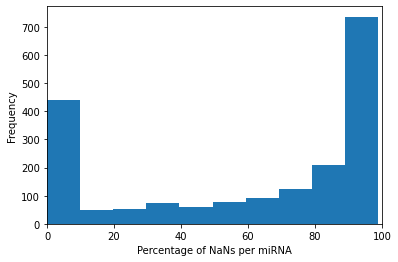

  Number mirnas after: 988 with average 28.81% of NaNs.


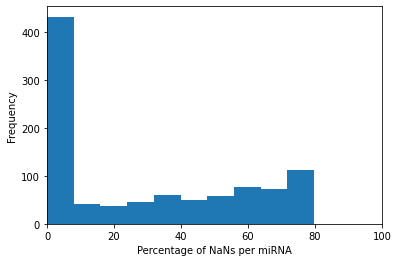

While translating mirna IDs, for 10 (1.01%) mirnas no ID could be found. 978 mirnas left.
filter out mirnas with variance <= 0.2
  Number mirnas before: 978


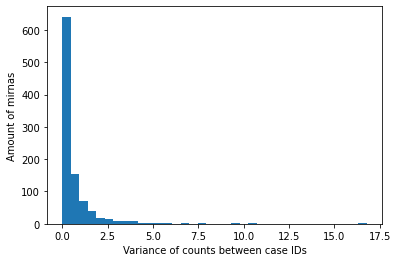

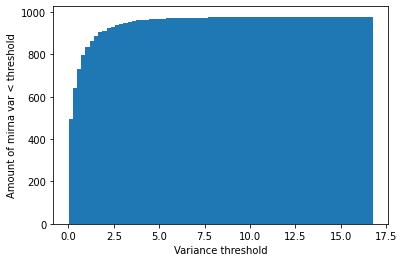

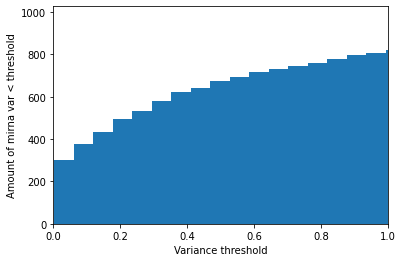

  Number mirnas after: 525


,TCGA-KN-8419-01,TCGA-KL-8346-01,TCGA-KN-8422-01,TCGA-KN-8431-11,TCGA-KM-8440-01,TCGA-KO-8414-01,TCGA-KL-8323-01,TCGA-KM-8639-01,TCGA-KO-8415-11,TCGA-KL-8329-11,...,TCGA-KM-8438-01,TCGA-KL-8340-01,TCGA-KO-8406-01,TCGA-KO-8408-01,TCGA-KM-8443-01,TCGA-KM-8442-01,TCGA-KL-8332-11,TCGA-KL-8327-01,sample,mature_name
6,2.133185,NaN,0.471811,2.465996,0.293100,NaN,0.365156,4.960849,3.266722,3.716075,...,0.566009,NaN,1.090414,1.394396,0.179300,0.337864,2.625418,0.731942,MIMAT0000765,hsa-miR-335-5p
7,3.503195,4.447707,3.105749,3.391232,3.037309,4.419848,3.432216,2.789729,3.586709,4.930151,...,2.536915,3.535995,3.538015,3.679102,2.878281,4.233346,3.949308,4.926588,MIMAT0000764,hsa-miR-339-5p
8,3.612425,3.315511,3.861983,3.821122,2.777719,3.125820,3.180473,3.949170,4.060992,5.378086,...,3.736501,2.736154,1.489019,2.557360,2.193239,2.709411,4.376474,2.614086,MIMAT0000761,hsa-miR-324-5p
9,4.616464,5.193729,4.417849,4.383196,3.743185,4.879833,3.931606,4.923476,4.613770,4.340069,...,3.960723,3.499438,3.619797,4.488382,3.675702,4.095454,4.376453,4.003315,MIMAT0000760,hsa-miR-331-3p
10,7.218711,5.287701,6.094130,7.007872,6.516809,5.417363,6.521786,6.212210,8.452705,7.036344,...,7.282332,6.863381,6.797278,7.188169,5.731833,6.350536,8.790510,6.336443,MIMAT0000763,hsa-miR-338-3p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,2.958590,4.933270,5.115080,3.615619,4.143342,1.919288,5.539652,4.745263,3.219260,3.019976,...,3.804149,3.737916,4.165053,4.188916,3.804264,3.298455,2.660585,5.046859,MIMAT0004586,hsa-miR-15b-3p
969,2.819797,2.453618,2.793262,1.867498,1.798299,3.672161,2.817558,1.170724,1.670003,0.900967,...,1.766325,1.853455,3.154682,1.839534,2.852081,2.189626,1.244184,4.018092,MIMAT0003298,hsa-miR-629-3p
970,1.877254,0.291500,0.717855,1.216845,0.926820,2.572038,2.008887,0.295677,1.888152,1.146778,...,1.766295,0.660640,0.537800,1.602181,0.612940,0.841183,0.685479,0.868778,MIMAT0003294,hsa-miR-625-5p
972,1.650331,0.533887,0.471811,1.524187,0.744867,1.348064,0.365156,0.540961,0.872891,2.159982,...,0.714191,NaN,0.293800,1.060632,0.843264,0.178800,1.418397,0.411900,MIMAT0003297,hsa-miR-628-3p


In [8]:
#download GDC ChGR37 miRNA expression data from XENA
def download_miRNA_data(tcga_path,dataset):
    if not tcga_path.exists():
        !mkdir tcga_path
    if not Path(tcga_path/'miRNA_HiSeq_gene').is_file():
        print('Download miRNA expression data from TCGA')
        !wget 'https://tcga.xenahubs.net/download/TCGA.'$dataset'.sampleMap/miRNA_HiSeq_gene.gz'
        !gunzip miRNA_HiSeq_gene.gz
        !mv miRNA_HiSeq_gene tcga_path
        
#Filter mirnas: if not min 80% of patients not nan kick out all mirna counts for that mirna
#10% ignore for model, Rest keep only samples that have expression?????
def filter_nan_mirnas(mirna_counts, threshold, nr_caseids):
    nan_patientcounts = mirna_counts.isnull().sum(axis=1)/nr_caseids*100
    print(f'filter NaN mirnas\n  Number mirnas before: {len(nan_patientcounts)} with average {(nan_patientcounts.sum()/len(nan_patientcounts)):.2f}% of NaNs.')
    nan_patientcounts.plot(kind='hist')
    axes = plt.gca().set_xlim([0,100])
    plt.xlabel("Percentage of NaNs per miRNA") 
    plt.show()
    mirna_counts = mirna_counts[nan_patientcounts<threshold]
    nan_patientcounts = mirna_counts.isnull().sum(axis=1)/nr_caseids*100
    print(f'  Number mirnas after: {len(nan_patientcounts)} with average {(nan_patientcounts.sum()/len(nan_patientcounts)):.2f}% of NaNs.')
    nan_patientcounts.plot(kind='hist')
    axes = plt.gca().set_xlim([0,100])
    plt.xlabel("Percentage of NaNs per miRNA") 
    plt.show()
    return mirna_counts

#variance filter, drop mirna counts that show no variance (not on gene level but on all caseids)
def filter_no_variance(mirna_counts,used_caseids,threshold=0.2):
    print(f'filter out mirnas with variance <= {threshold}\n  Number mirnas before: {len(mirna_counts)}') 
    here_caseids = list(used_caseids).copy()
    here_caseids.extend(['sample'])
    mirna_level = mirna_counts[here_caseids]
    mirna_level = mirna_level.assign(all_counts=mirna_level[used_caseids].apply(lambda column : [item for item in column if not pd.isna(item)],axis=1)).drop(used_caseids, 1)
    mirna_level['var'] = mirna_level['all_counts'].apply(lambda list_val : np.var(list_val,axis=0))
    mirna_level['var'].plot(kind='hist', bins=36)
    plt.ylabel("Amount of mirnas") 
    plt.xlabel("Variance of counts between case IDs")
    plt.show()
    mirna_level['var'].plot(kind='hist', bins=72, cumulative=True)
    plt.ylabel("Amount of mirna var < threshold") 
    plt.xlabel("Variance threshold")
    plt.show()
    mirna_level['var'].plot(kind='hist', bins=288, cumulative=True)
    axes = plt.gca().set_xlim([0,1])
    plt.ylabel("Amount of mirna var < threshold") 
    plt.xlabel("Variance threshold")
    plt.show()
    mirna_level['keep_mirna'] = mirna_level['var'] > threshold
    mirna_counts = mirna_counts.merge(mirna_level[['sample','keep_mirna']], how='inner', left_on='sample', right_on='sample')
    mirna_counts = mirna_counts[mirna_counts.keep_mirna].drop('keep_mirna',axis=1)
    print(f'  Number mirnas after: {len(mirna_counts)}')
    return mirna_counts

file = Path(tcga_path/'miRNA_counts.parquet')
if file.is_file():
    mirna_counts = pd.read_parquet(file)
else:
    download_miRNA_data(tcga_path, dataset)
    mirna_counts = pd.read_csv(tcga_path/'miRNA_HiSeq_gene', delimiter='	')
    exon_counts_input = read_exon_counts(tcga_path)
    used_caseids = list(exon_counts_input.columns & mirna_counts.columns)
    nr_caseids = len(used_caseids)
    print(f'Exon and miRNA counts have {nr_caseids} common patient ids.')
    mirna_caseids = used_caseids.copy()
    mirna_caseids.extend(['sample'])
    mirna_counts = mirna_counts[mirna_caseids]
    mirna_counts = filter_nan_mirnas(mirna_counts,80,nr_caseids)
    trans = pd.read_parquet(path/'mature2mirna.parquet')
    mirna_counts = mirna_counts.merge(trans, left_on='sample',right_on='mature_acc', how='left').drop(['mature_acc'],axis=1)
    print(f'While translating mirna IDs, for {len(mirna_counts[mirna_counts.mature_name.isna()])} ({(len(mirna_counts[mirna_counts.mature_name.isna()])/len(mirna_counts))*100:.2f}%) mirnas no ID could be found. {len(mirna_counts[~mirna_counts.mature_name.isna()])} mirnas left.')
    mirna_counts = mirna_counts[~mirna_counts.mature_name.isna()]
    mirna_counts = filter_no_variance(mirna_counts,used_caseids)
    #mirna_counts.to_parquet(file)
mirna_counts

### Outer join exon counts with miRNA counts & Elastic Net Regression

In [9]:
#regression btw miRNA expression, exon expression
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

#split data into train and test subsets with trainsplit between 0 and 1
def split_train_test(data, train_split=0.8):
    train_split = int(train_split * len(data))
    train = data[:train_split]
    test = data[train_split:]
    return train, test

def run_elastic_net_regression(mirna_counts,exon_counts):
    models = {} #takes about 1 hour
    data_info = {}
    train_data = {}
    test_data = {}
    for mirna in mirna_counts['mature_name']:
        y_info = mirna_counts[mirna_counts['mature_name'] == mirna].melt(id_vars=['mature_name','sample'], var_name="case_id", value_name="mirna_count").dropna()
        X_info = y_info.merge(exon_counts,on='case_id',how='left').drop('mirna_count',axis=1)
        y = y_info.mirna_count
        X = X_info.drop(['sample','mature_name','case_id'],axis=1)
        X_train, X_test = split_train_test(X)
        y_train, y_test = split_train_test(y)
        regr = ElasticNet(random_state=0)
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        rms = mean_squared_error(y_test, y_pred, squared=False) #best RMSE = 0
        models[mirna] = (rms, regr)
        data_info[mirna] = (X_info, y_info)
        train_data[mirna] = (X_train, y_train)
        test_data[mirna] = (X_test, y_test)
    with open((tcga_path/'models.pickle'),"wb") as file:
        pickle.dump(models,file, protocol=pickle.HIGHEST_PROTOCOL)
    with open((tcga_path/'data_info.pickle'),"wb") as file:
        pickle.dump(data_info,file, protocol=pickle.HIGHEST_PROTOCOL)
    with open((tcga_path/'train_data.pickle'),"wb") as file:
        pickle.dump(train_data,file, protocol=pickle.HIGHEST_PROTOCOL)
    with open((tcga_path/'test_data.pickle'),"wb") as file:
        pickle.dump(test_data,file, protocol=pickle.HIGHEST_PROTOCOL)
    exon_ids = list(list(data_info.values())[0][0].columns)[3:] #list of exon IDs
    with open((tcga_path/'exon_ids.pickle'),"wb") as file:
        pickle.dump(exon_ids,file, protocol=pickle.HIGHEST_PROTOCOL)
    return models, data_info, train_data, test_data
#models, data_info, train_data, test_data = run_elastic_net_regression(mirna_counts,exon_counts)

filter out models if RMSE >= 0.5
  Number models before: 525


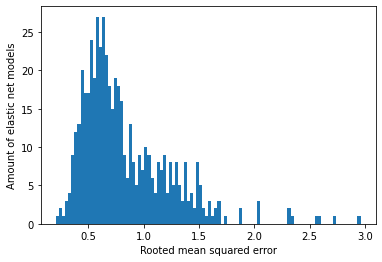

  Number models after: 92


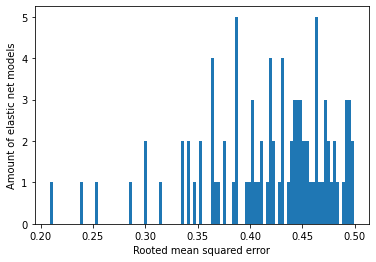

filter genes with no negative coefficients
  Number mirna-exon-bindingsites before: 9727988


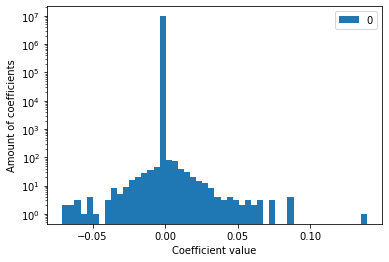

  Number mirna-exon-bindingsites after: 1723


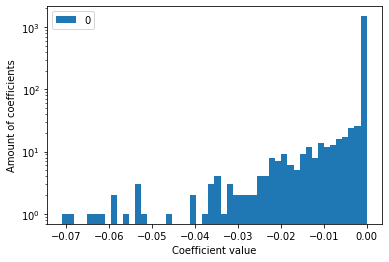

filter out exons with non negative coefficients
  Number mirna-exon-bindingsites before: 1723


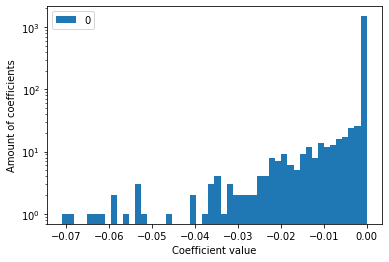

  Number mirna-exon-bindingsites after: 256


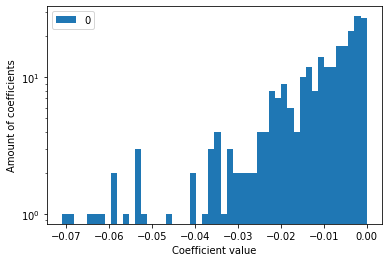

,mature_name,exon_id,coefficient,transcript_id,gene_id
16265,hsa-miR-30e-5p,ENSE00000431371,-0.004894,ENST00000393155,ENSG00000011465
265605,hsa-miR-1287-3p,"ENSE00000718724,ENSE00003835972",-0.021229,ENST00000600166,ENSG00000001626
266249,hsa-miR-1287-3p,ENSE00000718848,-0.001350,ENST00000396225,ENSG00000035720
266270,hsa-miR-138-1-3p,ENSE00000718848,-0.002412,ENST00000396225,ENSG00000035720
266282,hsa-miR-542-5p,ENSE00000718848,-0.012452,ENST00000396225,ENSG00000035720


In [2]:
#filter mirna models by rmse score
def filter_models_by_rmse(models, threshold=0.5):
    #plot histogram of rooted mean squared error score
    print(f'filter out models if RMSE >= {threshold}\n  Number models before: {len(models)}')
    plt.hist([rmse_score for (rmse_score, model) in models.values()],bins=100)
    plt.xlabel("Rooted mean squared error")
    plt.ylabel("Amount of elastic net models")
    plt.show()
    models = {mirna:values for mirna, values in models.items() if values[0] < threshold} 
    print(f'  Number models after: {len(models)}')
    plt.hist([rmse_score for (rmse_score, model) in models.values()],bins=100)
    plt.xlabel("Rooted mean squared error")
    plt.ylabel("Amount of elastic net models")
    plt.show()
    return models

def plot_coefficients(coefficients):
    #plot coefficients per mirna
    mirna_level = coefficients.groupby('mature_name').agg({'coefficient':(lambda x: list(x)),'gene_id':(lambda x: len(set(x))),'exon_id':'count','mature_name':'first'})
    fig1, ax1 = plt.subplots(figsize=(20,4))
    plt.xlabel('miRNA')
    plt.ylabel('coefficients')
    ax1.boxplot(mirna_level.coefficient.to_list())
    ax1.set_xticklabels(mirna_level.mature_name, rotation=90, ha='right')
    plt.show()

#per miRNA model: if gene no negative coefficients: filter it, drop
def filter_coefficients_per_gene(coefficients, models, tcga_path):
    with open((tcga_path/'exon_ids.pickle'),'rb') as handle:
        exon_ids = pickle.load(handle) #read in exon ids for column
    #1 row per mirna, 1 column by exon, values = coefficients
    coefficients = pd.DataFrame(coefficients,index=models.keys(),columns=exon_ids)
    #1 row per mirna-exon
    coefficients.index.names = ['mature_name']
    coefficients = coefficients.reset_index()
    coefficients = coefficients.melt(id_vars=['mature_name'], var_name="exon_id", value_name="coefficient")
    # add gene_id
    exon2gene = pd.read_parquet(tcga_path/'exon2gene.parquet')
    coefficients = coefficients.merge(exon2gene)
    gene_coeff = coefficients.copy()                                                  #TODO min<0 right? oder falsch oO
    gene_coeff = gene_coeff.groupby(['mature_name','gene_id'], as_index=False).agg({'coefficient':(lambda x: min(x)<0)}).rename({'coefficient':'keep_gene'},axis=1)
    nr_filtered_genes = len(gene_coeff[~gene_coeff.keep_gene].drop_duplicates(subset=['gene_id']))
    #print(f'Per miRNA on average {nr_filtered_genes/(len(gene_coeff.drop_duplicates(subset=['gene_id'])))}% of genes are filtered out.')
    #print(f'On average {len(gene_coeff[gene_coeff.keep_gene].drop_duplicates(subset=['gene_id']))/len(coefficients)} genes per miRNA are left.')
    coefficients = coefficients.merge(gene_coeff[['mature_name','gene_id','keep_gene']], how='left')
    print(f'filter genes with no negative coefficients\n  Number mirna-exon-bindingsites before: {len(coefficients)}')
    all_coefficients = coefficients.coefficient.values 
    pd.DataFrame(all_coefficients).plot(kind='hist', bins=50)
    plt.yscale("log")
    plt.ylabel("Amount of coefficients")
    plt.xlabel("Coefficient value")
    plt.show()
    coefficients = coefficients[coefficients.keep_gene].drop(['keep_gene'],axis=1)
    print(f'  Number mirna-exon-bindingsites after: {len(coefficients)}')
    all_coefficients = coefficients.coefficient.values 
    pd.DataFrame(all_coefficients).plot(kind='hist', bins=50)
    plt.yscale("log")
    plt.ylabel("Amount of coefficients")
    plt.xlabel("Coefficient value")
    plt.show()
    return coefficients

#per miRNA model: if gene no negative coefficients: filter it, drop
def filter_coefficients_per_exon(coefficients):
    coefficients['keep_exon'] = coefficients['coefficient'] < 0
    print(f'filter out exons with non negative coefficients\n  Number mirna-exon-bindingsites before: {len(coefficients)}')
    all_coefficients = coefficients.coefficient.values
    pd.DataFrame(all_coefficients).plot(kind='hist', bins=50)
    plt.yscale("log")
    plt.ylabel("Amount of coefficients")
    plt.xlabel("Coefficient value")
    plt.show()
    coefficients = coefficients[coefficients.keep_exon].drop(['keep_exon'],axis=1)
    print(f'  Number mirna-exon-bindingsites after: {len(coefficients)}')
    all_coefficients = coefficients.coefficient.values 
    pd.DataFrame(all_coefficients).plot(kind='hist', bins=50)
    plt.yscale("log")
    plt.ylabel("Amount of coefficients")
    plt.xlabel("Coefficient value")
    plt.show()
    return coefficients
    
import pickle
with open((tcga_path/'models.pickle'), 'rb') as handle:
    models = pickle.load(handle)
models = filter_models_by_rmse(models)
coefficients = [model.coef_ for (rmse_score, model) in models.values()]
coefficients = filter_coefficients_per_gene(coefficients, models, tcga_path)
#plot_coefficients(coefficients)
#coefficients.to_parquet(tcga_path/'bs_counts_filtered_gene.parquet')
coefficients = filter_coefficients_per_exon(coefficients)
#plot_coefficients(coefficients)
#coefficients.to_parquet(tcga_path/'bs_counts_filtered_exon.parquet')
coefficients.head()

2314


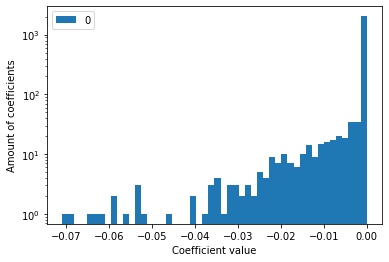

In [68]:
all_coefficients = coefficients.coefficient.values 
#all_coefficients = [item for sublist in coefficients for item in sublist]
print(len(all_coefficients))
pd.DataFrame(all_coefficients).plot(kind='hist', bins=50)
plt.yscale("log")
plt.ylabel("Amount of coefficients")
plt.xlabel("Coefficient value")
plt.show()

<ipython-input-49-bd7e799a9078>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(list(coefficients.mature_name), rotation=90, ha='right')
/nfs/home/users/l.hackl/.conda/envs/thesis/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


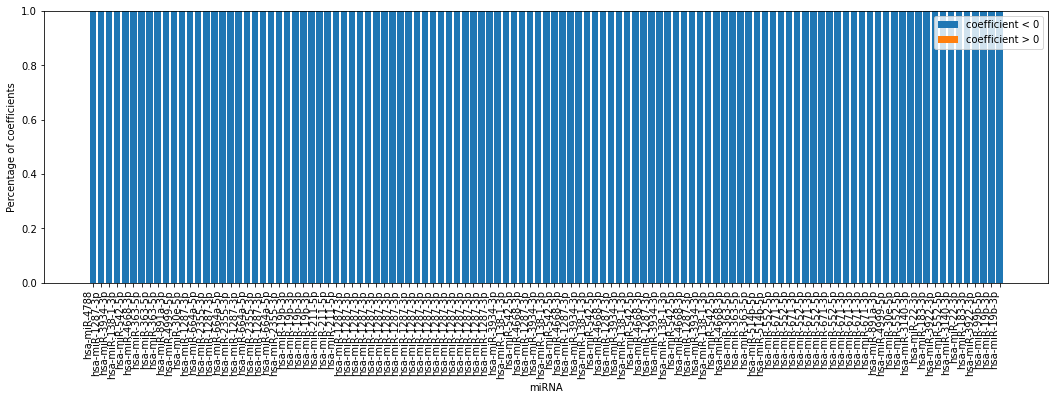

In [49]:
#If exon affected by mirna (= negative coefficient), compare all exoncounts of 1 gene, Compare exons without bs with exons with bs
#coefficients[coefficients.coefficient < 0]
#TODO
is_sm_zero = [(coefficient < 0.0) for coefficient in coefficients.coefficient]
is_bg_zero =[(coefficient > 0.0) for coefficient in coefficients.coefficient]
fig1, ax1 = plt.subplots(figsize=(18,5))
plt.bar(coefficients.mature_name,is_sm_zero,label='coefficient < 0')
plt.bar(coefficients.mature_name,is_bg_zero, bottom=is_sm_zero,label='coefficient > 0')
ax1.set_xticklabels(list(coefficients.mature_name), rotation=90, ha='right')
plt.xlabel("miRNA")
plt.ylabel("Percentage of coefficients")
plt.legend()
plt.show()
#plot affected exon count - uneffected exon counts per gene or average

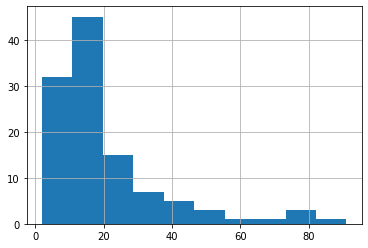

In [26]:
#nr_genes / model plot
coeff_per_sample = coefficients.groupby('mature_name').count()
genes_per_sample = coefficients.drop_duplicates(subset=['mature_name','gene_id']).groupby('mature_name').count()
#genes_per_sample.coefficient.hist()
coeff_per_sample.coefficient.hist()
plt.show()

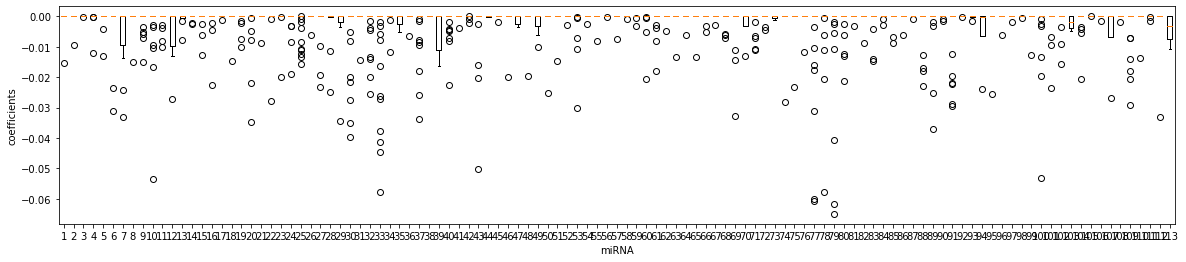

In [44]:
#TODO & color if tarpmir bs
coefficients = pd.read_parquet(tcga_path/'bs_counts_new.parquet')
fig1, ax1 = plt.subplots(figsize=(20,4))
plt.xlabel('miRNA')
plt.ylabel('coefficients')
#ax1.set_xticklabels(list(coefficients.groupby('mature_name').mature_name), rotation=90, ha='right')
ax1.boxplot(coefficients.groupby('mature_name').agg({'coefficient':(lambda x: list(x))}).coefficient.to_list())
plt.show()